# **CS310-Third Year Project: `Real-time Human Attribute Analysis Web Application`** 
---

# Comparison of 3 different Sentiment Analysis tools using the _amazon-fine-food-reviews_ Dataset

#### Author: *`Neema Raiyat`*

We will be mainly comparing NLTK's (Python's Natural Language Toolkit) `VADER` sentiment analyzer with HuggingFace's `RoBERTa`.

Research both in more detail.

---

In [192]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import random

import nltk

plt.style.use('ggplot')     # Style sheet used for plots

In [193]:
df = pd.read_csv('../data/amazon-fine-food-reviews/Reviews.csv')    # Read in data
df = df.head(1000)      # Dataset has dimensions: (568454, 10), but we will just look at top 1000
print(df.shape)

(1000, 10)


# EDA (Exploratory Data Analysis) on the Dataset


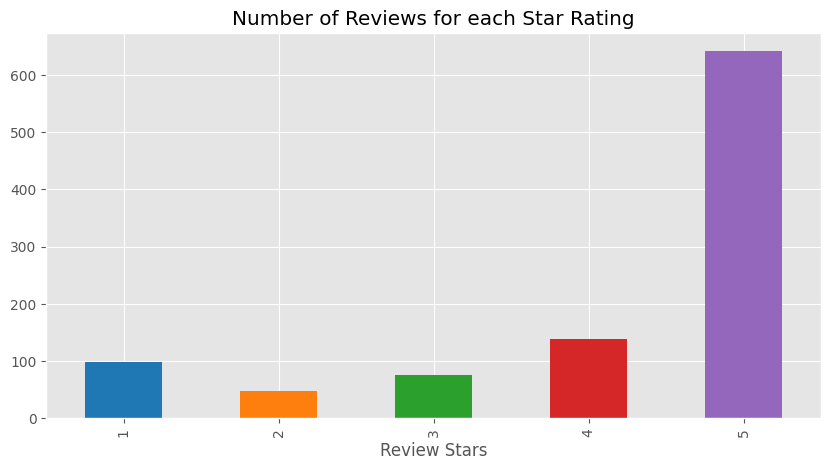

In [194]:
def plot_eda(df):
    ax = df['Score'].value_counts().sort_index() \
        .plot(kind='bar',
            title='Number of Reviews for each Star Rating',
            figsize=(10, 5),
            color=mcolors.TABLEAU_COLORS)
    ax.set_xlabel('Review Stars')
    plt.show()
plot_eda(df)

* This shows that we are very biased towards positive reviews in this dataset!

> As a result we will remove some of the 5-star rating reviews:

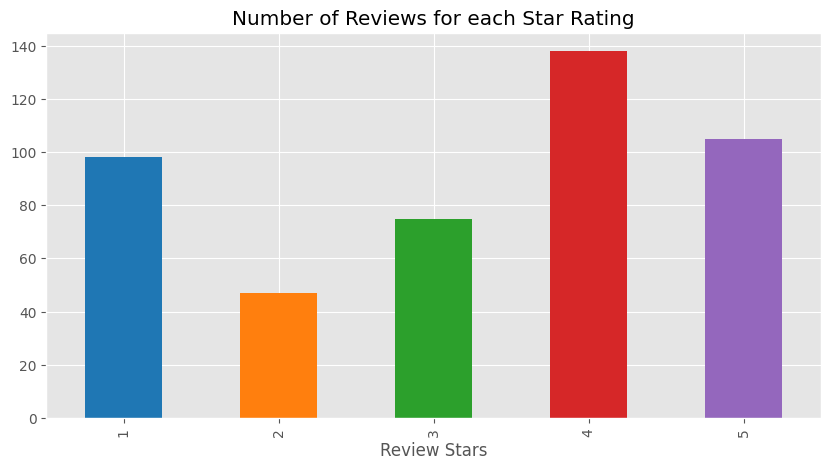

In [195]:
for i, row in df.iterrows():
    if row['Score'] == 5 and random.randint(1,6) > 1:       # Randomly remove 80% of 5 star reviews
        df.drop(i, inplace=True)    
plot_eda(df)

Dataset is more balanced now

In [196]:
example = df['Text'][50]
print(f"Example sentence: {example}\n")

tokens = nltk.word_tokenize(example)    # Converts the text into a more parsable format
print(f"Tokens: {tokens[:10]}\n")

tagged = nltk.pos_tag(tokens)           # Part-of-speech for each token, i.e. is it a singular noun (NN), verb, present tense, 3rd person singular (VBZ) etc.
print(f"Part-of-Speech: {tagged[:10]}\n")       # list of tags can be found here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

Example sentence: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.

Tokens: ['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

Part-of-Speech: [('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ')]



---

# **Model 1:** `VADER` (Valence Aware Dictionary and sEntiment Reasoner) Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

> **Weakness:** This lexicon-based approach doesn't account for the relationships *between* words (i.e. _context_), which is very important in human speech.

In [197]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

positive_sentence = 'I am so happy!'
negative_sentence = 'I hate this so much!'

print(sia.polarity_scores(positive_sentence))
# first 3 keys are scales from 0 to 1
# Compound is from -1 to +1
print('\n')
print(sia.polarity_scores(negative_sentence))



{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}


{'neg': 0.571, 'neu': 0.429, 'pos': 0.0, 'compound': -0.6114}


In [198]:
# Run the sentiment analyzer on the entire dataset
df_2 = {}
for i, row in df.iterrows():
    text = row['Text']
    myid = row['Id']
    df_2[myid] = sia.polarity_scores(text)

result = pd.DataFrame(df_2).T
result = result.reset_index().rename(columns={'index': 'Id'})
result = result.merge(df, how='left')

# `VADER` Results on the dataset

This bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and provides some indication of the uncertainty around that estimate using error bars. Bar plots include 0 in the quantitative axis range, and they are a good choice when 0 is a meaningful value for the quantitative variable, and you want to make comparisons against it.

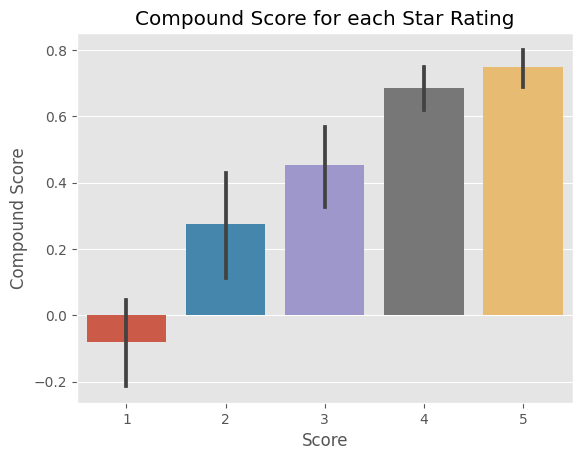

In [199]:
ax = sns.barplot(data=result, x='Score', y='compound')
ax.set_title('Compound Score for each Star Rating')
ax.set_ylabel('Compound Score')
plt.show()

* This shows that e.g. 3 star scores tend to be rated a compound score of _~0.45_ with an uncertainty of _~0.2_
* The plot shows exactly what we would expect, the higher rating the review has been labelled as, the higher the compound score will be

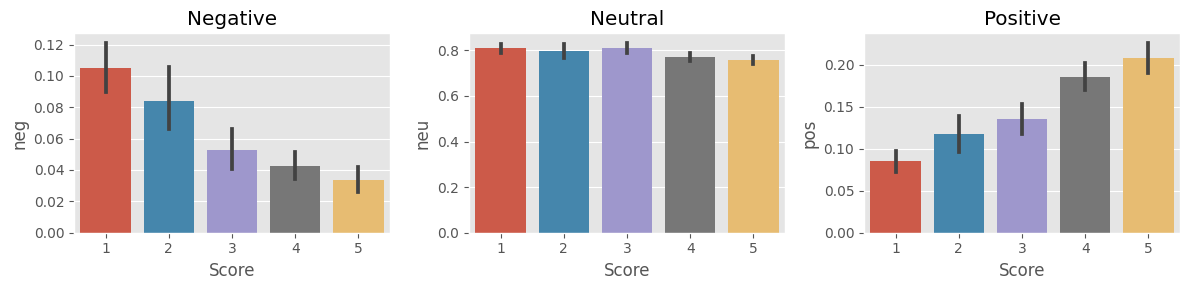

In [200]:
_, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=result, x='Score', y='neg', ax=axs[0])
sns.barplot(data=result, x='Score', y='neu', ax=axs[1])
sns.barplot(data=result, x='Score', y='pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

* This once again shows what we would expect, look at the `Negative` plot: it becomes more negative of a comment as the star review decreases, and vice versa in the `Positive` plot.

# **Model 2:** `RoBERTa` Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

Vader model wouldn't really be able to pick up on relationships between words and this is important because human language depends a lot on context, so a sentence with a lot of negative words, could be sarcastic and therefore actually be a positive sentence. Vader wouldn't be able to pick up on this. But these transformer-based deep learning models pick up on context.

In [201]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"    # Pulls down pre-trained model weights. 
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [202]:
def polarity_scores_roberta(sentence):
    encoded_text = tokenizer(sentence, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'rob_neg' : scores[0],
        'rob_neu' : scores[1],
        'rob_pos' : scores[2]
    }
    return scores_dict

In [208]:
print(polarity_scores_roberta(positive_sentence))
print(polarity_scores_roberta(negative_sentence))

{'rob_neg': 0.0016519687, 'rob_neu': 0.0065048463, 'rob_pos': 0.99184316}
{'rob_neg': 0.9798523, 'rob_neu': 0.0163629, 'rob_pos': 0.0037847457}


In [204]:
res = {}
for i, row in df.iterrows():
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vad_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
# results_df.head(5)

Broke for id 529


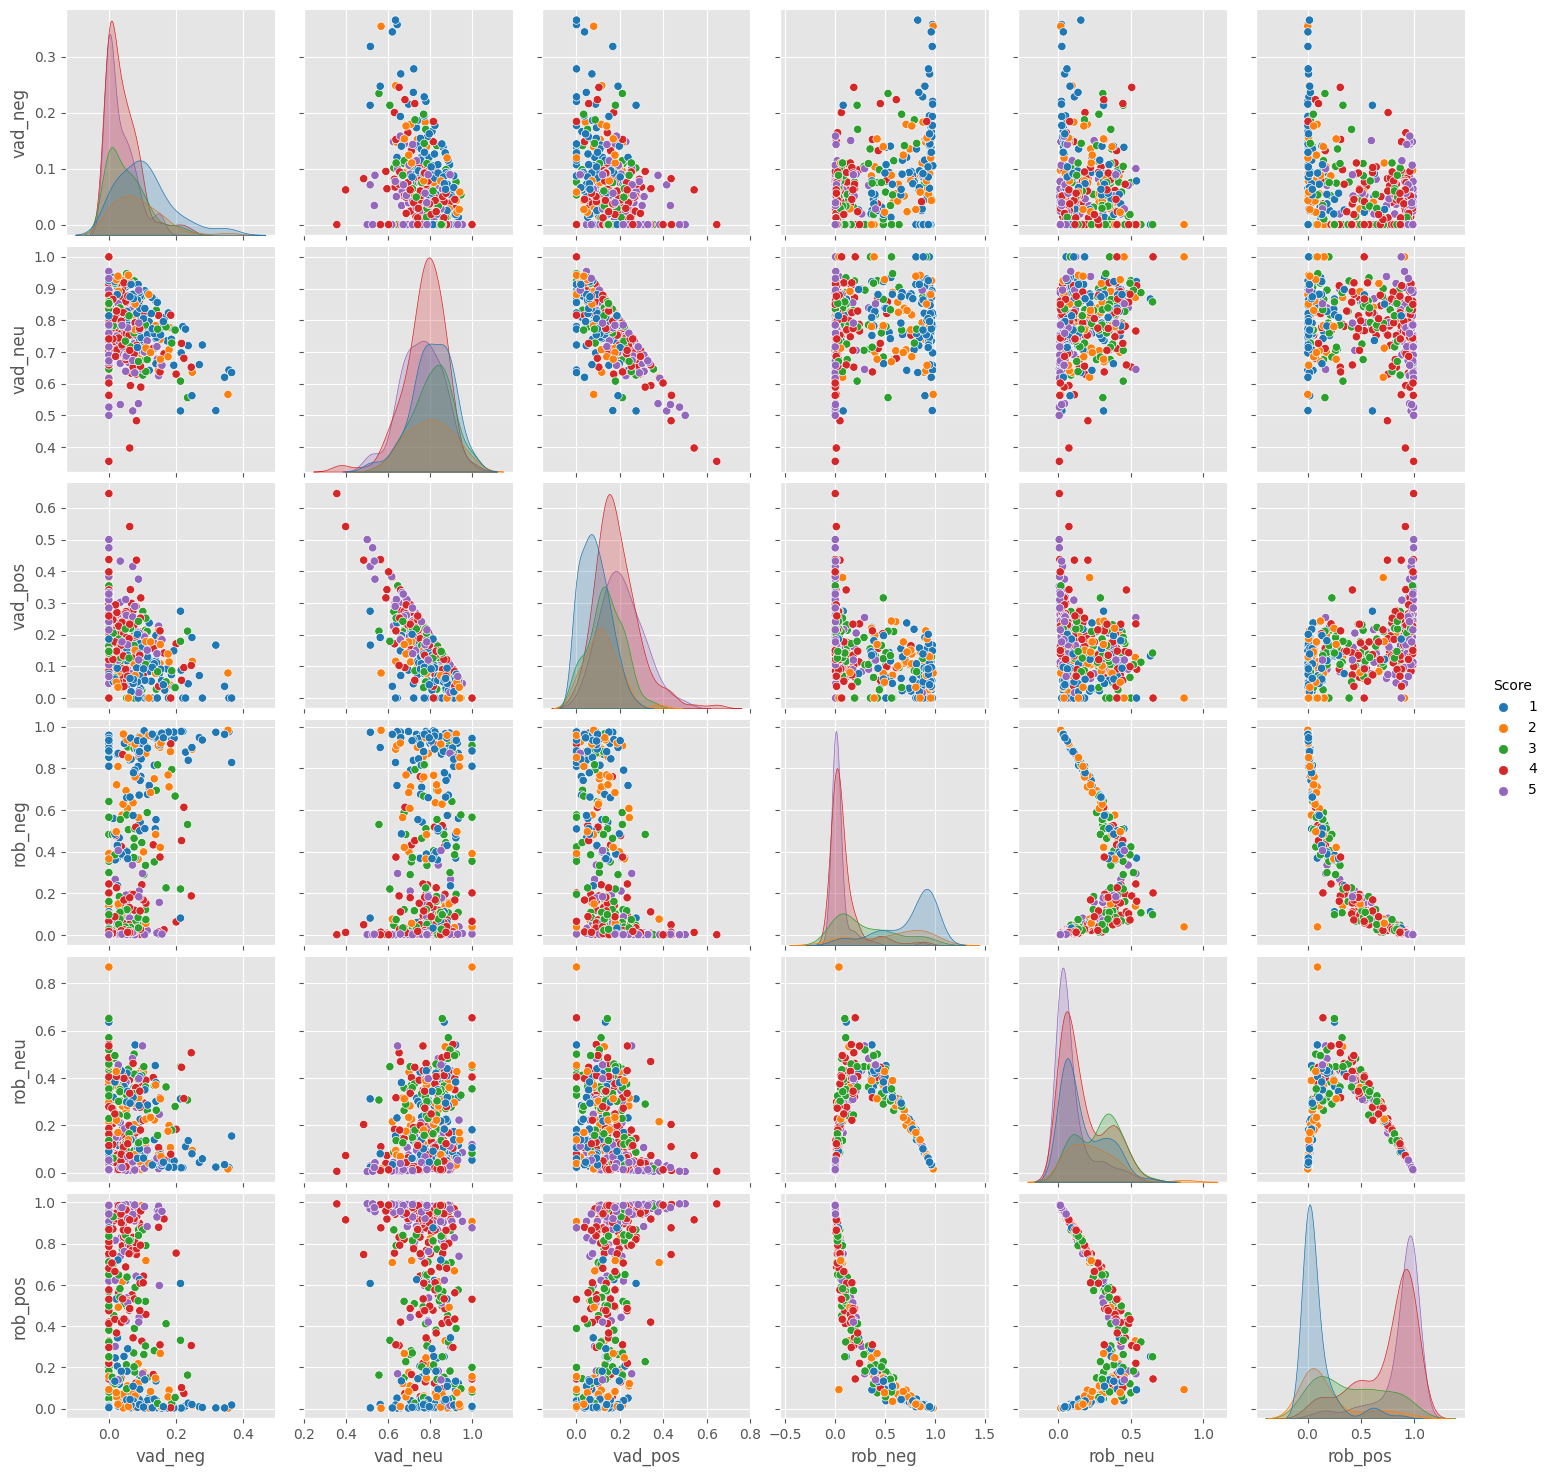

In [205]:
sns.pairplot(data=results_df,
             vars=['vad_neg', 'vad_neu', 'vad_pos',
                  'rob_neg', 'rob_neu', 'rob_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Understanding this graph

Key on the right. Score: 1-Blue, 2-Orange, 3-Green, 4-Red, 5-Purple

Look at the X-axis and Y-axis labels of these plots!

If we want to compare how good roberta's positive results are compared to vaders positive results, we look at x = vader_pos and y = roberta_pos. This is the 3rd from the left graph on the bottom row, (last row column 3 (1-indexed)). You can see that the x and y-axis are up to 1. You can see the positive reviews lean more towards roberta showing that roberta tends to give 5 star reviews more positive ratings than vader_pos.

When looking at the same thing on the x and y axis e.g. bottom right graph, obviously it would normally just be a diagnol line since x = y since x = rob_pos and y = rob_pos. It looks like there are multiple hills on these plots, but there are only 5, they just cross over. So instead an average is taken, so most positive reviews (purple) are given a rating generally very high/confident 0.95. Also because there were far more positive samples in the dataset than negative (see the EDA cell).

You can see, on the rightmost graph (x=rob_pos, y=rob_pos), blue=1 star rating, is at 0, meaning that the positive component for 1-star reviews is 0 which is what we want. If we look at (x=rob_neu, y=rob_neu), we can see that 1,4 and 5, and also 2 (look at the peak of orange) are all almost 0, which is good, as this means 1,2,4,5 star reviews are given a neutral component of 0. The only thing that should be given a high neutral component is 3-star reviews, which you can see the green peak is furthest to the right (has the highest value rob_neu value). If we look at (x=rob_neg, y=rob_neg), only 1-star (blue) has a high value (rightmost of the peaks), all the other star ratings have low negative components!

This same analysis goes for the vader. But you can see in the vader that the peaks are all a lot closer together, meaning the model is not as good as distinguishing between ratings and is less confident. As a result, the `Roberta` pretrained model performs better in terms of accuracy, as expected, since it takes into account context. However, `VADER` is faster. 

# **Model 3:** The `Transformers` Pipeline

In [206]:
from transformers import pipeline       # HUGGING FACE

sent_pipeline = pipeline("sentiment-analysis")

print(sent_pipeline('I sure do love sentiment analysis so much!'))
print(sent_pipeline('This is maybe slightly good but im not too sure, a bit iffy'))
# 'score' is the confidence rating, (high score = high confidence)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9997627139091492}]
[{'label': 'NEGATIVE', 'score': 0.9918590188026428}]


* This gives a binary output of POSITIVE or NEGATIVE, and is hence less useful if we want a continuous measurement

# **Model 4:** `TextBlob`

The Polarity result ranges from highly Positive to highly negative (1 to -1)

The subjectivity ranges from 0(Objective) to 1(Subjective).

In [207]:
from textblob import TextBlob

sentence = "This is a very average sentence with no sentiment"

testimonial = TextBlob(sentence)
testimonial.sentiment
# # Output object: Sentiment(polarity=-0.195, subjectivity=0.52)
# testimonial.sentiment.polarity          # -1 to +1
# testimonial.sentiment.subjectivity    # 0 to 1, 0 is very objective, 1 is very subjective, so essentially it's a confidence rating
                                        # the lower, the more confident

Sentiment(polarity=-0.195, subjectivity=0.52)